In [82]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import imblearn
from sklearn import metrics



from utils.general_utils import get_outlier_info, get_outlier_val_counts
from utils.saver_utils import save_normalizer, load_normalizer
from utils.saver_utils import save_dataset, load_dataset 

In [16]:
from sklearn.ensemble import RandomForestClassifier
from utils.general_utils import save_model
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

import imblearn
from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA

In [3]:
datasetv2_save_path = "dataset/dataset_v2"
trainX, trainY, testX, testY = load_dataset(path=datasetv2_save_path)
scalerTrainX = load_normalizer(path=datasetv2_save_path, task='classification')

Caution, loading dataset in order!.. Check arguments
Loading for classification task


C:\Users\sudar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.001s...
[t-SNE] Computed neighbors for 320 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 2.499638
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.354118
[t-SNE] KL divergence after 1000 iterations: 0.691738


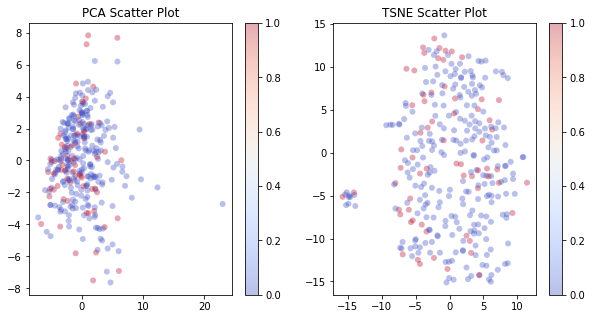

In [15]:
X = trainX
Labels = trainY

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X)

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

# Plot the TSNE and PCA visuals side-by-side
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(pca_2d[:,0], pca_2d[:,1], c = Labels,
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('PCA Scatter Plot')

plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = Labels,
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

## Training with Isolation Forest

In [ ]:
trainX, trainY, testX, testY 

In [32]:
train_negative_pcr_data = trainX[(trainY == 0).ravel()]
train_positive_pcr_data = trainX[(trainY == 1).ravel()]

test_negative_pcr_data = testX[(testY == 0).ravel()]
test_positive_pcr_data = testX[(testY == 1).ravel()]

In [116]:
print(f'True contamination % : {len(train_positive_pcr_data)/(len(train_negative_pcr_data) + len(train_positive_pcr_data))}')

True contamination % : 0.203125


In [117]:
2/10

0.2

In [131]:
# Training the Isolation Forest on the majority class
isolation_anomaly_det = IsolationForest(contamination=0.05)  
isolation_anomaly_det.fit(train_negative_pcr_data)

IsolationForest(contamination=0.05)

In [132]:
test_neg_preds = isolation_anomaly_det.predict(test_negative_pcr_data)

In [133]:
# Evaluate the model's performance
print("Test Normal data:")
print(classification_report([0] * len(test_negative_pcr_data), (test_neg_preds == -1).astype(int),
                           zero_division = 0))

Test Normal data:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        61
           1       0.00      0.00      0.00         0

    accuracy                           0.95        61
   macro avg       0.50      0.48      0.49        61
weighted avg       1.00      0.95      0.97        61



In [134]:
test_pos_preds = isolation_anomaly_det.predict(test_positive_pcr_data)

In [135]:
# Evaluate the model's performance
print("Test Anomaly data")
print(classification_report([1] * len(test_positive_pcr_data), (test_pos_preds == 1).astype(int),
                            zero_division = 0))

Test Anomaly data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97        19

    accuracy                           0.95        19
   macro avg       0.50      0.47      0.49        19
weighted avg       1.00      0.95      0.97        19



In [136]:
train_pos_preds = isolation_anomaly_det.predict(train_positive_pcr_data)

In [137]:
# Evaluate the model's performance
print("Train Anamoly Set:")
print(classification_report([1] * len(train_positive_pcr_data), (train_pos_preds == 1).astype(int),
                           zero_division = 0))

Train Anamoly Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.91      0.95        65

    accuracy                           0.91        65
   macro avg       0.50      0.45      0.48        65
weighted avg       1.00      0.91      0.95        65



In [138]:
test_preds = np.concatenate(((test_neg_preds == -1).astype(int),(test_pos_preds == 1).astype(int)))
true_labels_concat = np.concatenate((([0] * len(test_negative_pcr_data)), ([1] * len(test_positive_pcr_data))))

Balanced classification accuracy : 0.9490940465918896

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        61
           1       0.86      0.95      0.90        19

    accuracy                           0.95        80
   macro avg       0.92      0.95      0.93        80
weighted avg       0.95      0.95      0.95        80



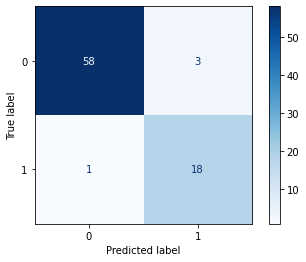

In [141]:
test_bas_error = balanced_accuracy_score(true_labels_concat, test_preds)
print(f'Balanced classification accuracy : {test_bas_error}')

print()

print(classification_report(true_labels_concat, test_preds))

confusion_matrix = metrics.confusion_matrix(true_labels_concat, test_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [122]:
# Training the Isolation Forest on the majority class
isolation_anomaly_det = IsolationForest(contamination=0.20)  
isolation_anomaly_det.fit(train_negative_pcr_data)

IsolationForest(contamination=0.2)

In [123]:
test_pos_preds = isolation_anomaly_det.predict(test_positive_pcr_data)
test_neg_preds = isolation_anomaly_det.predict(test_negative_pcr_data)

In [124]:
test_preds = np.concatenate(((test_neg_preds == -1).astype(int),(test_pos_preds == 1).astype(int)))
true_labels_concat = np.concatenate((([0] * len(test_negative_pcr_data)), ([1] * len(test_positive_pcr_data))))

Balanced classification accuracy : 0.7782571182053495

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        61
           1       0.56      0.74      0.64        19

    accuracy                           0.80        80
   macro avg       0.73      0.78      0.75        80
weighted avg       0.83      0.80      0.81        80



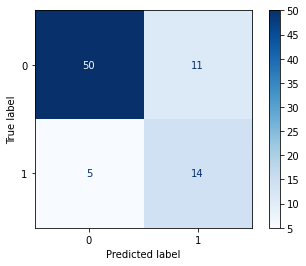

In [130]:
test_bas_error = balanced_accuracy_score(true_labels_concat, test_preds)
print(f'Balanced classification accuracy : {test_bas_error}')

print()

print(classification_report(true_labels_concat, test_preds))

confusion_matrix = metrics.confusion_matrix(true_labels_concat, test_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# TODO
1. Identify what happens if we decrease contamination more than we expect in the dataset